In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from astropy.coordinates import SkyCoord
from dlnpyutils.coords import lbd2xyz,xyz2lbd
from findinc import InclineDiskDist
from makegal import makedisk
from astropy.table import Table
from scipy.optimize import curve_fit
from scipy.stats import binned_statistic_2d

Text(0, 0.5, 'dec')

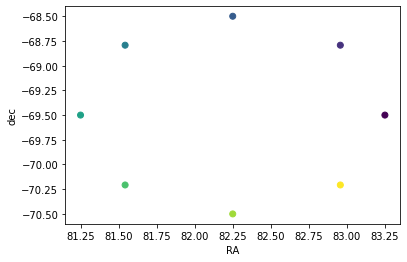

In [2]:
ra0 = 82.25
dec0 = -69.50
pa_y = 149.23 # line of nodes from Yumi 
io_y = 25.86 # inclination from Yumi 
d0_g = 49.59 # distance from Pietrzynski (2019)
a = np.arange(8)*np.pi/4
ra1 = ra0+np.cos(a)
dec1 = dec0+np.sin(a)
plt.scatter(ra1,dec1,c=a)
plt.xlabel('RA')
plt.ylabel('dec')

In [3]:
dist1 = InclineDiskDist(ra1,dec1,pa_y,io_y,d0_g)
dist1

array([49.46562232, 49.35176296, 49.38380012, 49.53507508, 49.71810185,
       49.83378052, 49.81316625, 49.66007076])

In [4]:
c_icrs = SkyCoord(ra=ra1*u.degree,dec=dec1*u.degree,frame='icrs')
c_gal = c_icrs.galactic
l1 = c_gal.l
b1 = c_gal.b
l1 = l1.dms[0]+l1.dms[1]/60+l1.dms[2]/3600
b1 = b1.dms[0]+b1.dms[1]/60+b1.dms[2]/3600

In [5]:
c0_icrs = SkyCoord(ra=ra0*u.degree,dec=dec0*u.degree,frame='icrs')
c0_gal = c0_icrs.galactic
l0 = c0_gal.l
b0 = c0_gal.b
l0 = l0.dms[0]+l0.dms[1]/60+l0.dms[2]/3600
b0 = b0.dms[0]+b0.dms[1]/60+b0.dms[2]/3600

In [6]:
x1,y1,z1 = lbd2xyz(l1,b1,dist1)

In [7]:
x0,y0,z0 = lbd2xyz(l0,b0,d0_g)

In [8]:
d01 = np.sqrt((x1-x0)**2+(y1-y0)**2+(z1-z0)**2)
x1 = x0+(x1-x0)/d01
y1 = y0+(y1-y0)/d01
z1 = z0+(z1-z0)/d01
np.sqrt((x1-x0)**2+(y1-y0)**2+(z1-z0)**2)

array([1., 1., 1., 1., 1., 1., 1., 1.])

Text(0, 0.5, 'Y')

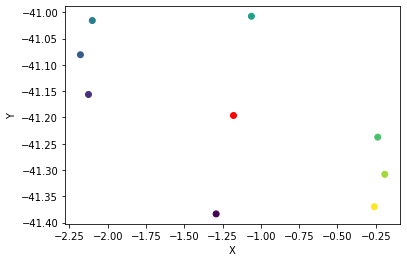

In [9]:
plt.scatter(x1,y1,c=a)
plt.scatter(x0,y0,c='r')
plt.xlabel('X')
plt.ylabel('Y')

Text(0, 0.5, 'Z')

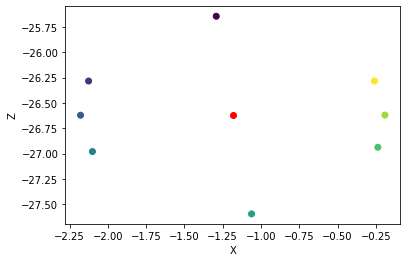

In [10]:
plt.scatter(x1,z1,c=a)
plt.scatter(x0,z0,c='r')
plt.xlabel('X')
plt.ylabel('Z')

Text(0, 0.5, 'Z')

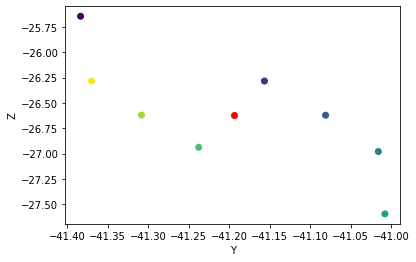

In [11]:
plt.scatter(y1,z1,c=a)
plt.scatter(y0,z0,c='r')
plt.xlabel('Y')
plt.ylabel('Z')

In [12]:
x2 = x1-x0
y2 = y1-y0
z2 = z1-z0

In [13]:
nx1 = np.zeros(8)
ny1 = np.zeros(8)
nz1 = np.zeros(8)
for i in range(8):
    nx1[i] = y2[i]*z2[i-1]-z2[i]*y2[i-1]
    ny1[i] = z2[i]*x2[i-1]-x2[i]*z2[i-1]
    nz1[i] = x2[i]*y2[i-1]-y2[i]*x2[i-1]

In [14]:
n2 = np.sqrt(sum(nx1)**2+sum(ny1)**2+sum(nz1)**2)
nx = sum(nx1/n2)
ny = sum(ny1/n2)
nz = sum(nz1/n2)
nx**2+ny**2+nz**2

0.9999999999999998

In [15]:
nx

0.11127072981723504

In [16]:
ny

0.9733110788354666

In [17]:
nz

0.20070966220408948

In [18]:
theta = np.arccos(nz)
phi = np.arccos(nx/np.sqrt(nx**2+ny**2))
if ny<0:
    phi = 2*np.pi-phi

In [19]:
def IDD2(out,pa,io,d0):
    return InclineDiskDist(out['RA'],out['DEC'],pa,io,d0)

In [20]:
lmass = 1.8e11#2d10
lsoft = 0.9*(lmass/1e9)**(1./3.)  # rscale
lmc0 = [lmass,lsoft,x0[0],y0[0],z0[0],-57,-226,221]
print('theta = {} degrees'.format(np.degrees(theta)))
print('phi = {} degrees'.format(np.degrees(phi)))
out0 = makedisk(lmc0,10000,theta=theta,
                phi=phi,noprint=True)
out1 = Table(out0,names=('MASS','SOFT','X','Y','Z',
                         'VX','VY','VZ'))
l,b,d = xyz2lbd(out1['X'],out1['Y'],out1['Z'])
out1['DIST'] = d

c_gal = SkyCoord(l=l*u.degree,b=b*u.degree,frame='galactic')
c_icrs = c_gal.icrs
out1['RA'] = c_icrs.ra
out1['DEC'] = c_icrs.dec
ra = out1['RA']
dec = out1['DEC']

pa_y = 149.23 # line of nodes from Yumi 
io_y = 25.86 # inclination from Yumi 
d0_g = 49.59 # distance from Pietrzynski (2019)


guess = [pa_y, io_y, d0_g] #guess parameters

popt,pcov = curve_fit(IDD2,out1,d,p0=guess,
                      bounds=(0,[360,90,np.inf]))

print('line of nodes = {}, inclination = {}'.format(popt[0],popt[1]))

theta = 78.42153879407073 degrees
phi = 83.47815413942413 degrees
USING 10000 STARS
line of nodes = 149.2663841870759, inclination = 25.41636172535626


Text(0, 0.5, 'dec')

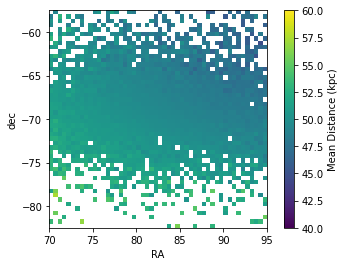

In [21]:
lbrange = [[70,95],[-82.5,-57.5]]
ret = binned_statistic_2d(out1['RA'],out1['DEC'],out1['DIST'],
                          statistic=np.mean,bins=50,
                          range=lbrange)
extent = lbrange[0]+lbrange[1]
plt.imshow(ret.statistic.T,origin='lower',extent=extent,vmin=40,
           vmax=60)
plt.colorbar(label='Mean Distance (kpc)')
plt.xlabel('RA')
plt.ylabel('dec')